In [58]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel
df = pd.read_csv(r'./data tables/steering stats cleaned.csv')


In [ ]:

df['bf_precision'] = df['bf_coverage']/df['systems_area']
df['bf_recall'] = df['bf_coverage']/df['protection_area']
df['bf_Fscore'] = 2 * df['bf_recall'] * df['bf_precision'] / (df['bf_recall'] + df['bf_precision'] + 1e-10)
df.rename(columns={'Fscore': 'combined_Fscore'}, inplace=True)
df.rename(columns={'recall': 'combined_recall'}, inplace=True)
df.rename(columns={'precision': 'combined_precision'}, inplace=True)
df['combined_Fscore'] = 2 * df['combined_Fscore']


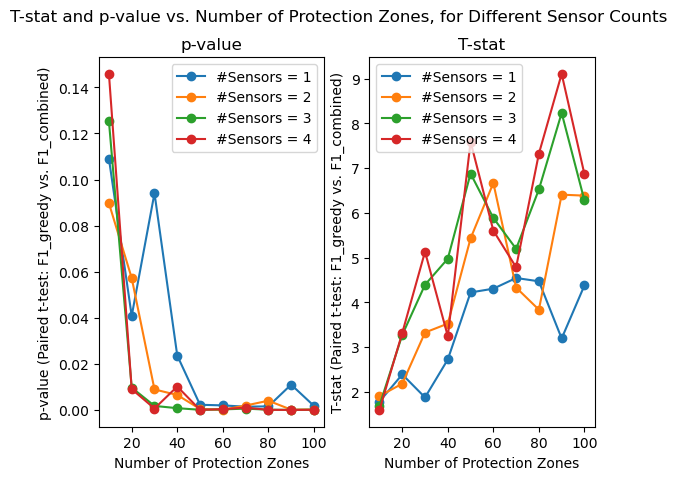

In [70]:
results = []
group_cols = ["Number_of_systems", "Number_of_areas"]

for (pz, ns), group in df.groupby(group_cols):
    # Extract the F1 scores for each algorithm
    f1_a = group["combined_Fscore"]
    f1_b = group["bf_Fscore"]
    
    # Make sure we have at least 2 runs for a valid t-test
    # (In practice, you'd want even more runs than that for meaningful results.)
    if len(group) >= 2:
        t_stat, p_val = ttest_rel(f1_a, f1_b)
    else:
        t_stat, p_val = float("nan"), float("nan")  # Not enough data to test
    
    results.append((pz, ns, p_val, t_stat))


# 3. Put the results into a DataFrame
results_df = pd.DataFrame(results, columns=["Number_of_systems","Number_of_areas","p_value","t_stat"])

# 4. Plot p-value vs. # of protection zones, with a separate line for each # of sensors
fig,ax = plt.subplots(1,2)
for ns_val in sorted(results_df["Number_of_systems"].unique()):
    subset = results_df[results_df["Number_of_systems"] == ns_val]
    # Sort by protection zones so lines are drawn correctly
    subset = subset.sort_values("Number_of_areas")
    
    ax[0].plot(
        subset["Number_of_areas"],
        subset["p_value"],
        marker='o',
        label=f"#Sensors = {ns_val}"
    )
    ax[0].set_xlabel("Number of Protection Zones")
    ax[0].set_ylabel("p-value (Paired t-test: F1_greedy vs. F1_combined)")
    ax[0].set_title("p-value")
    ax[0].legend()
    ax[1].plot(
        subset["Number_of_areas"],
        subset["t_stat"],
        marker='o',
        label=f"#Sensors = {ns_val}"
    )

    ax[1].set_xlabel("Number of Protection Zones")
    ax[1].set_ylabel("T-stat (Paired t-test: F1_greedy vs. F1_combined)")
    ax[1].set_title("T-stat")
    ax[1].legend()
fig.suptitle("T-stat and p-value vs. Number of Protection Zones, for Different Sensor Counts")
plt.show()

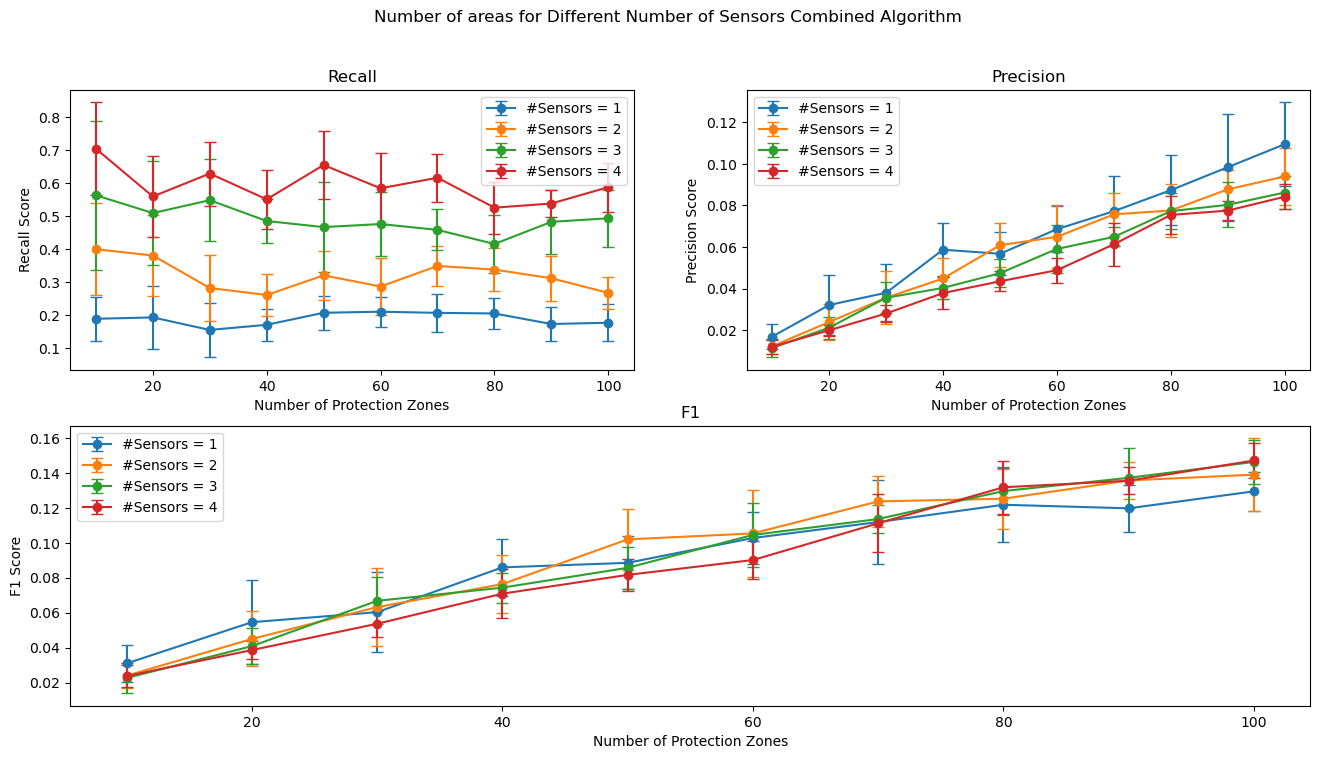

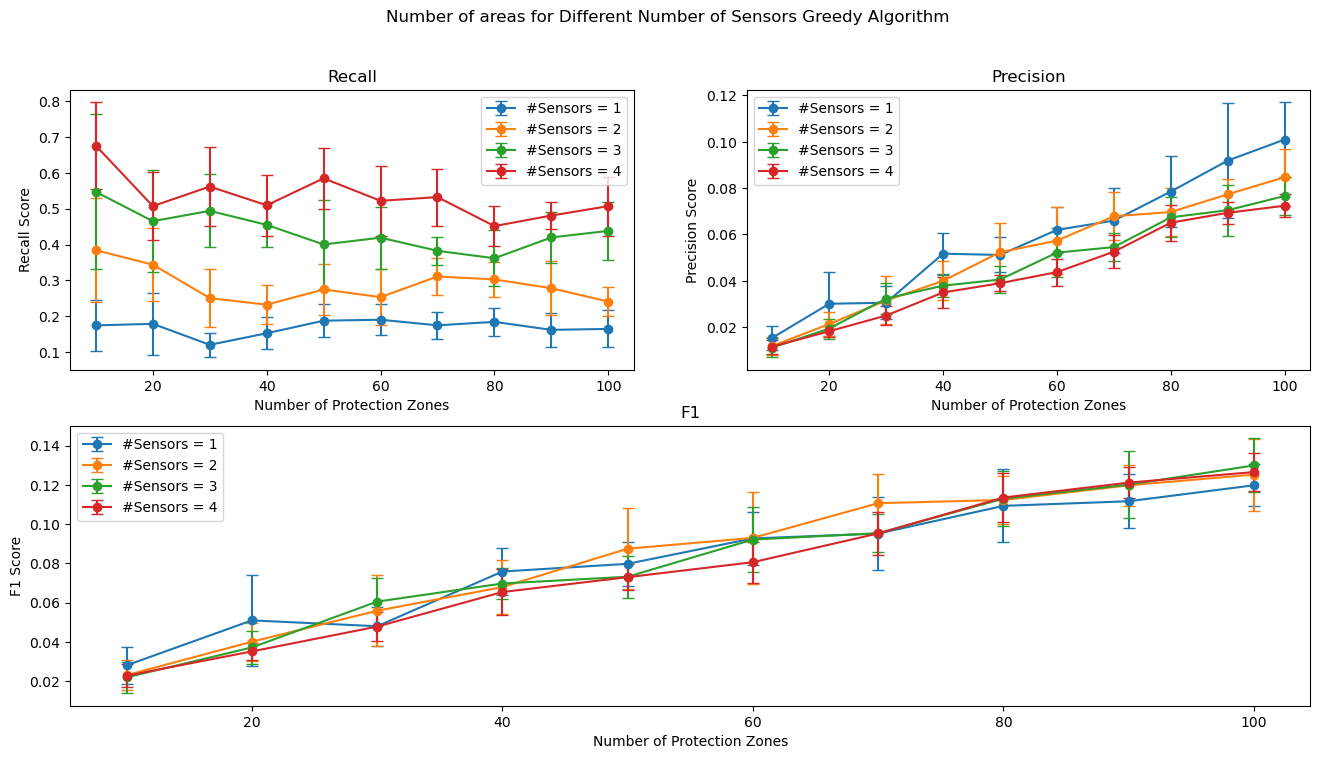

In [71]:
algo_names = ['Combined','Greedy']
for j,algo in enumerate(['combined_','bf_']):
    fig = plt.figure(figsize=(16,8))
    gs = fig.add_gridspec(2, 2)
    names = ['Recall','Precision','F1']
    for i,measure in enumerate(['recall','precision','Fscore']):
        
        grouped = (
            df.groupby(["Number_of_systems", "Number_of_areas"])[algo+measure]
            .agg(["mean", "std"])
            .reset_index()
        )
        
        if i == 0:
        # Subplot 1 (top-left) - Precision
            ax = fig.add_subplot(gs[0, 0])
        elif i == 1:
            ax = fig.add_subplot(gs[0, 1])
        elif i == 2:
            ax = fig.add_subplot(gs[1, :])
        # Get the distinct protection-zone values
        protection_zone_values = grouped["Number_of_systems"].unique()

        # Plot mean F1 vs. number_of_sensors for each protection-zone value
        for pz_val in sorted(protection_zone_values):
            subset = grouped[grouped["Number_of_systems"] == pz_val]
            ax.errorbar(
                x=subset["Number_of_areas"],
                y= subset["mean"],
                yerr= subset["std"],
                fmt='-o',
                capsize=4,
                label=f"#Sensors = {pz_val}"
            )

        ax.set_xlabel("Number of Protection Zones")
        ax.set_ylabel(f"{names[i]} Score")
        ax.set_title(f'{names[i]}')
        ax.legend()
    fig.suptitle(f"Number of areas for Different Number of Sensors {algo_names[j]} Algorithm ")
    plt.show()